In [178]:
import os 
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt 
import astroalign
import scipy.signal as sig
import scipy.optimize as opt
import peakutils

%matplotlib widget

In [2]:
# Directory where data is stored
_cache_dir =  "c:\\Users\\avipa\\OneDrive\\Documents\\Coursework\\_cache\\GalaxyRotation"

In [3]:
# Load Data 
hdu_lst = np.array([])
for f in os.listdir(_cache_dir):
    hdu_lst = np.append(hdu_lst, fits.open(os.path.join(_cache_dir,f)))

In [4]:
# Keys to sort fits files 
obj_lst = np.array([0]*len(hdu_lst), dtype='object')
for i in range(len(hdu_lst)):
    obj_lst[i] = hdu_lst[i].header['OBJECT']

print('filenames', np.unique(obj_lst))

filenames ['UGC11876_Group4&5' 'arc_ne_3' 'bias' 'dark_10' 'dark_420'
 'superblue_flats']


In [11]:
# Sort frames by label
bias_frames = hdu_lst[np.where(obj_lst=='bias')
                      ]
dark10_frames = hdu_lst[np.where(obj_lst=='dark_10')]
dark420_frames = hdu_lst[np.where(obj_lst=='dark_420')]

df_frames = hdu_lst[np.where(obj_lst=='superblue_flats')]

sci_frames = hdu_lst[np.where(obj_lst=='UGC11876_Group4&5')]

arc_frames = hdu_lst[np.where(obj_lst=='arc_ne_3')]

### Calibration of KAST spectrum

In [39]:
arc_frames[0].header

SIMPLE  =                    T / NORMAL FITS IMAGE                              
BITPIX  =                   16 / DATA PRECISION                                 
NAXIS   =                    2 / NUMBER OF IMAGE DIMENSIONS                     
NAXIS1  =                  725 / NUMBER OF COLUMNS                              
NAXIS2  =                 2725 / NUMBER OF ROWS                                 
CRVAL1U =                  409 / COLUMN ORIGIN                                  
CRVAL2U =                 3400 / ROW ORIGIN                                     
CDELT1U =                    1 / COLUMN CHANGE PER PIXEL                        
CDELT2U =                   -1 / ROW CHANGE PER PIXEL                           
OBSNUM  =                 1016 / OBSERVATION NUMBER                             
IDNUM   =                    3 / IMAGE ID                                       
UGEOM   =                    4 / UCAM READOUT GEOMETRY                          
DGEOM   =                   

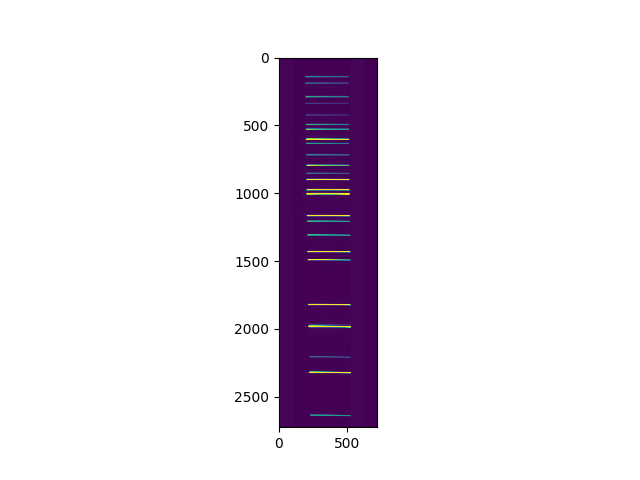

In [42]:
arc_full = np.median(np.stack([b.data for b in arc_frames]),axis=0)
plt.figure()
plt.imshow(arc_full, vmin=np.percentile(arc_full,3),vmax=np.percentile(arc_full,99))

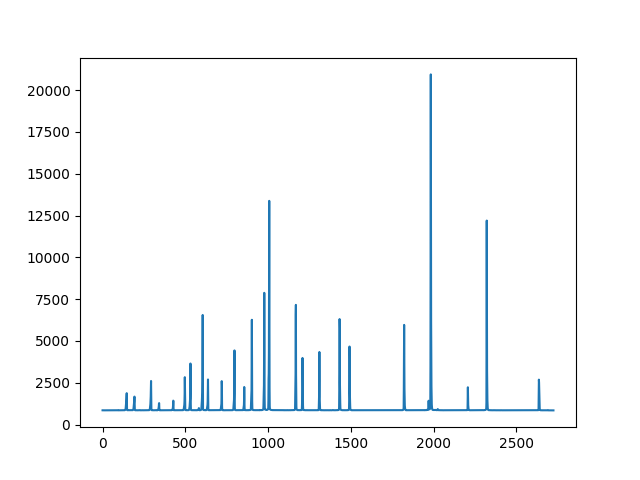

In [55]:
plt.figure()
plt.plot(arc_full[:,300])

In [50]:
sig.find_peaks(arc_full[:,300],height=(1800,21000))

(array([ 146,  293,  497,  531,  605,  637,  720,  797,  856,  902,  977,
        1007, 1168, 1208, 1310, 1432, 1492, 1822, 1983, 2207, 2321, 2636],
       dtype=int64),
 {'peak_heights': array([ 1877.,  2606.,  2833.,  3651.,  6554.,  2696.,  2597.,  4434.,
          2247.,  6266.,  7878., 13379.,  7157.,  3983.,  4340.,  6309.,
          4666.,  5960., 20942.,  2229., 12199.,  2686.])})

In [51]:
# Mapping between arc_full peaks and callibration spectrum wavelength peaks
res = np.array([[2321,7245.17], [2207, 7173.94], [1983, 7032.41],
                [1822,6929.47],[1432,6678.2], [1168,6506.53], [1007,6402.25],
                [605,6143.06],[293,5944.83],[146,5852.49]])

In [255]:
res[:,0]

array([2321., 2207., 1983., 1822., 1432., 1168., 1007.,  605.,  293.,
        146.])

In [256]:
def quad(x,a,b,c):
    return a*x**2 + b*x + c

res2 = opt.curve_fit(quad, res[:,0], res[:,1])

x_lst = np.linspace(0,2500)
y_lst = [quad(x, res2[0][0], res2[0][1], res2[0][2]) for x in x_lst]

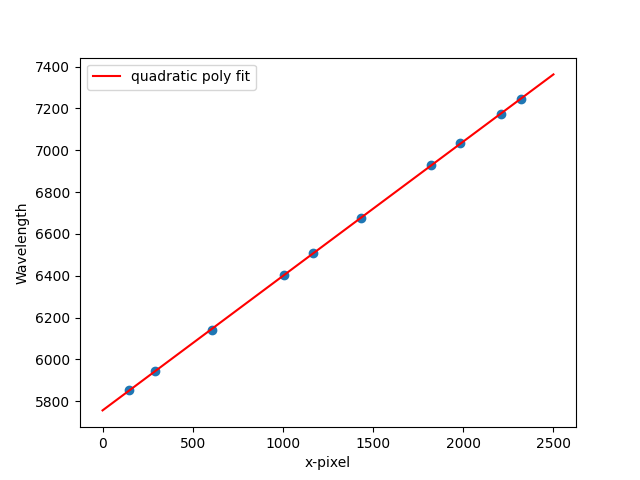

In [257]:
plt.figure()
plt.scatter(res[:,0], res[:,1])
plt.plot(x_lst, y_lst, c='red', label=f'quadratic poly fit')
plt.xlabel("x-pixel")
plt.ylabel("Wavelength")
plt.legend()

In [71]:
# H-alpha line is at
lambda_Halp = 6562.8 # Angstroms
pixel_Halp = quad(lambda_Halp, res2[0][0], res2[0][1], res2[0][2])

In [72]:
pixel_Halp

1254.5132007659868

### Callibration of Dome Flats: 
- We fit a polynomial curve to the median flat field spectrum and divide it by the fit to produce a normalized flat. 
- We divide the spectra by this normalized flat 

In [73]:
dome_flat_full = np.median(np.stack([b.data for b in df_frames]),axis=0)
sci_full = np.median(np.stack([b.data for b in sci_frames]),axis=0)

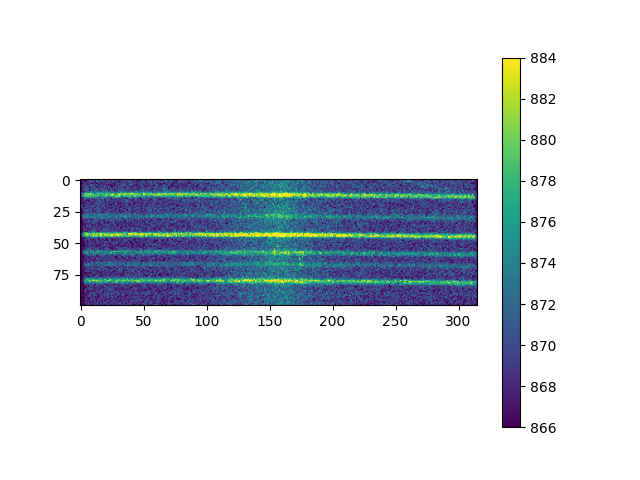

In [145]:
yreg = [1200,1300]
xreg = [205,520]

plt.figure()
plt.imshow(sci_full[yreg[0]:yreg[1],xreg[0]:xreg[1]], vmin=np.percentile(sci_full[yreg[0]:yreg[1],xreg[0]:xreg[1]],3), 
           vmax=np.percentile(sci_full[yreg[0]:yreg[1],xreg[0]:xreg[1]],99))
plt.colorbar()

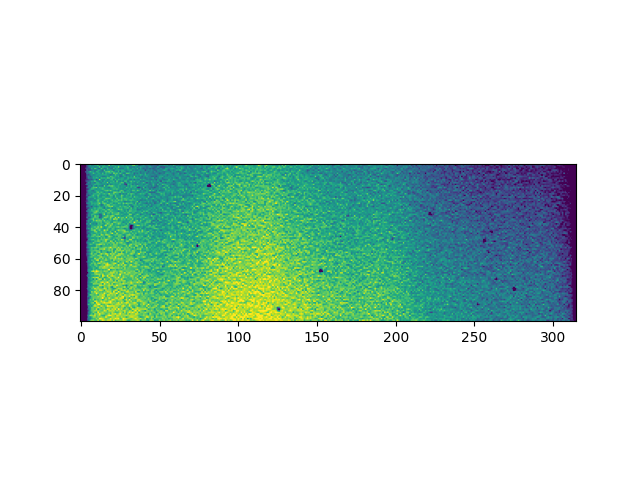

In [140]:
plt.figure()
plt.imshow(dome_flat_full[yreg[0]:yreg[1],xreg[0]:xreg[1]], vmin=np.percentile(dome_flat_full[yreg[0]:yreg[1],xreg[0]:xreg[1]],3), 
           vmax=np.percentile(dome_flat_full[yreg[0]:yreg[1],xreg[0]:xreg[1]],99))

In [232]:
def reduce_data(bias, dark10, dark420, dome_flat, science):

    dark10_exptime = dark10[0].header['EXPTIME']
    dark420_exptime = dark10[0].header['EXPTIME']
    df_exptime = dome_flat[0].header['EXPTIME']
    sci_exptime = science[0].header['EXPTIME']

    yreg = [60,2675]
    bias        = [b.data[yreg[0]:yreg[1],xreg[0]:xreg[1]] for b in bias] # [yreg[0]:yreg[1],xreg[0]:xreg[1]]
    dark10      = [b.data[yreg[0]:yreg[1],xreg[0]:xreg[1]] for b in dark10]
    dark420     = [b.data[yreg[0]:yreg[1],xreg[0]:xreg[1]] for b in dark420]
    dome_flat   = [b.data[yreg[0]:yreg[1],xreg[0]:xreg[1]] for b in dome_flat]
    science     = [b.data[yreg[0]:yreg[1],xreg[0]:xreg[1]] for b in science]

    # Median Bias Frames
    bias_full = np.median(np.stack([b for b in bias]),axis=0)

    # Median Dark Frames 
    dark10_full = np.median(np.stack([(b - bias_full) for b in dark10]),axis=0)

    dark420_full = np.median(np.stack([(b - bias_full) for b in dark420]),axis=0)

    # Median Dome Flats
    dome_flat_full = np.zeros(bias[0].shape)
    for i in range(0,science[0].shape[0]):
        dome_flat_full[i] = np.median(np.stack([( ((b[i,:]-bias_full[i,:])) \
                                            - (dark10_full[i,:]) )/ \
                                            np.median(b[i,:]) for b in dome_flat]), axis=0)

    # Median Science Frames
    sci_full = np.median(np.stack([(((b-bias_full)) - (dark420_full))/dome_flat_full for b in science]), axis=0)

    return sci_full, dome_flat_full
    

In [233]:
sci_red,df_full = reduce_data(bias_frames, dark10_frames, dark420_frames, df_frames, sci_frames)

In [388]:
fregy = [1300,1400]
fregx = [100,220]

sci_fin = sci_red[fregy[0]:fregy[1],fregx[0]:fregx[1]]

In [389]:
sci_fin.shape

(100, 120)

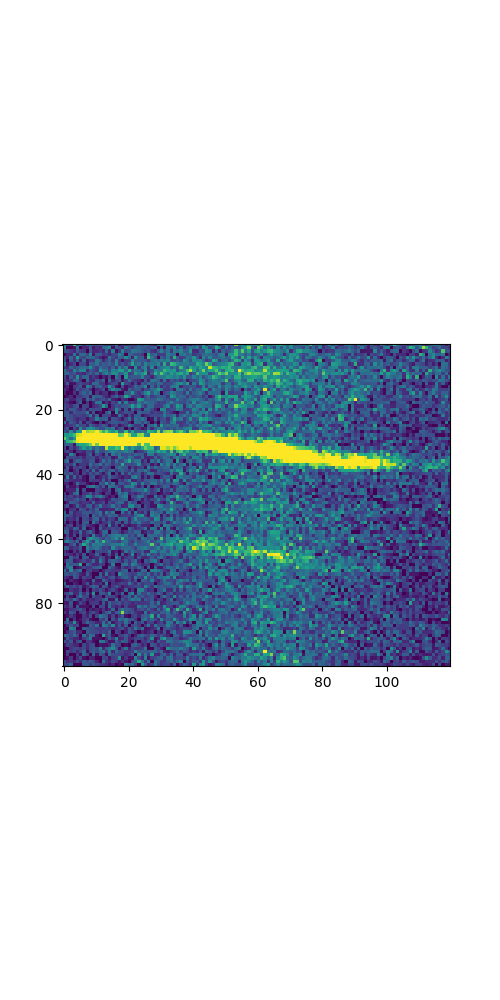

In [390]:
plt.figure(figsize=(5,10))
plt.imshow(sci_fin,vmin=np.nanpercentile(sci_fin,3),vmax=np.nanpercentile(sci_fin,97))
# plt.colorbar()

In [391]:
# Define a fitting function (e.g., a Gaussian)
def gaussian(x, a, x0, sigma):
    return a * np.exp(-((x - x0)**2) / (2 * sigma**2))

In [392]:
lambdas = np.array([0]*sci_fin.shape[1],dtype=np.float64)
for i in range(sci_fin.shape[1]):
    try:
        x = [quad(x, res2[0][0], res2[0][1], res2[0][2]) for x in range(len(sci_fin[:,i]))]
        y = sci_fin[:,i]

        # Initial peak estimation
        peak_idx = np.argmax(y)  # Index of the approximate peak
        x_peak = x[peak_idx]     # x-coordinate of approximate peak
        y_peak = y[peak_idx]     # y-value of approximate peak

        # Extract points around the peak for fitting
        window = 20  # Number of points around the peak
        start = max(0, peak_idx - window // 2)
        end = min(len(x), peak_idx + window // 2)
        x_fit = x[start:end]
        y_fit = y[start:end]


        # Fit the Gaussian to the data
        initial_guess = [y_peak, x_peak, 1.0]  # Amplitude, center, width
        params, _ = opt.curve_fit(gaussian, x_fit, y_fit, p0=initial_guess)
        print(x_peak)
        lambdas[i] = params[1]
        y_mod = [gaussian(x,params[0],params[1],params[2]) for x in x_fit]
    except:
        pass

5775.247234684207
5775.8902109513665
5775.8902109513665
5775.8902109513665
5775.247234684207
5775.247234684207
5775.247234684207
5775.247234684207
5775.247234684207
5775.8902109513665
5775.247234684207
5775.247234684207
5775.247234684207
5775.8902109513665
5775.247234684207
5775.8902109513665
5775.8902109513665
5775.8902109513665
5775.247234684207
5775.8902109513665
5775.8902109513665
5775.8902109513665
5775.247234684207
5775.247234684207
5775.8902109513665
5775.247234684207
5775.247234684207
5775.8902109513665
5775.8902109513665
5775.247234684207
5775.8902109513665
5775.8902109513665
5775.8902109513665
5775.8902109513665
5775.8902109513665
5775.8902109513665
5775.8902109513665
5775.8902109513665
5775.8902109513665
5775.247234684207
5775.8902109513665
5775.8902109513665
5775.8902109513665
5775.8902109513665
5775.8902109513665
5775.8902109513665
5776.533186658539
5775.8902109513665
5775.8902109513665
5776.533186658539
5776.533186658539
5776.533186658539
5776.533186658539
5776.5331866585

In [393]:
params

array([  23.28347853, 5790.94949063,   13.22628928])

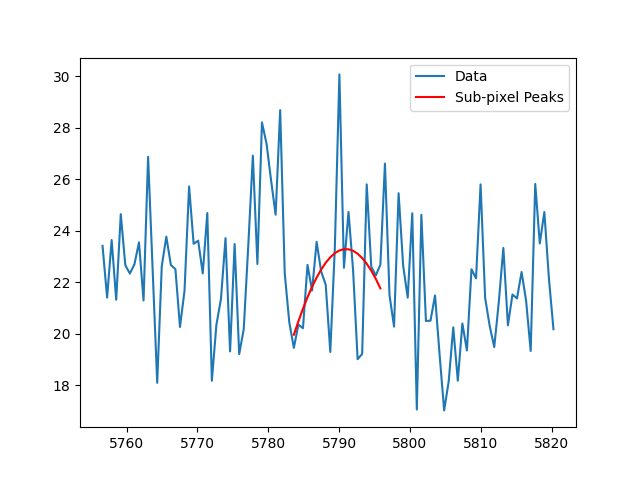

In [394]:
# Plot results
plt.figure()
plt.plot(x, y, label="Data")
plt.plot(x_fit, y_mod, color="red", label="Sub-pixel Peaks")
plt.legend()
plt.show()

In [349]:
sci_fin.shape[1]//2

60

In [395]:
lambda_0 = lambdas[sci_fin.shape[1]//2]
print("Lambda_0", lambda_0)
c = 2.9e5
dl = lambdas - lambda_0
vel = (dl/lambda_0) * c

Lambda_0 5776.798330383961


In [396]:
plate_scale = 0.43 * 0.00000485 # rad/pixel
dist = 183262.828 # km

dist_lst = []
for i in range(sci_fin.shape[1]):
    dist_lst.append(dist*np.tan(plate_scale*i))
dist_lst = np.array(dist_lst)
dist_lst = dist_lst - dist_lst[sci_fin.shape[1]//2]

In [402]:
vel = vel[np.where((vel > -200) & (vel < 200))]
dists = dist_lst[np.where((vel > -200) & (vel < 200))]

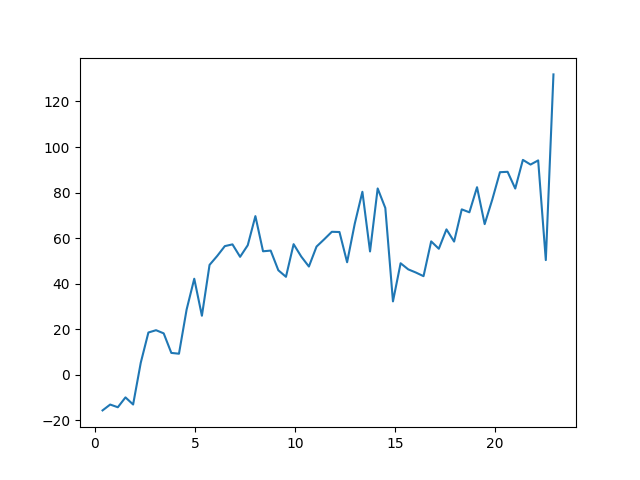

In [405]:
plt.figure()
plt.plot(-1*dists[:60],-1*vel[:60])

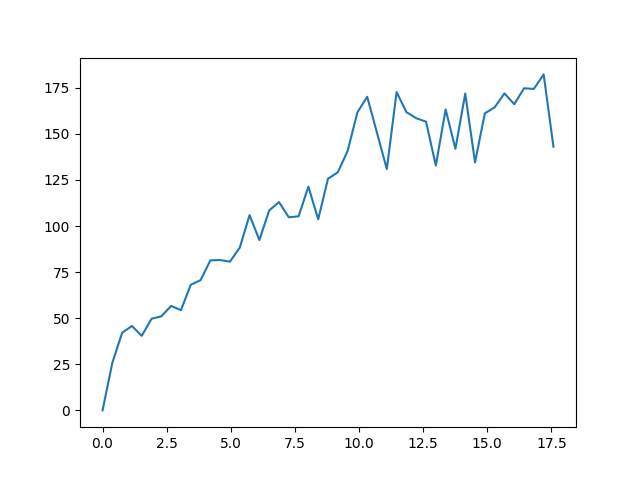

In [404]:
plt.figure()
plt.plot(dists[60:],vel[60:])

In [375]:
dist_lst

array([-22.93167779, -22.54948316, -22.16728853, -21.7850939 ,
       -21.40289928, -21.02070465, -20.63851002, -20.25631539,
       -19.87412076, -19.49192614, -19.10973151, -18.72753688,
       -18.34534225, -17.96314762, -17.580953  , -17.19875837,
       -16.81656374, -16.43436911, -16.05217448, -15.66997986,
       -15.28778523, -14.9055906 , -14.52339597, -14.14120134,
       -13.75900671, -13.37681208, -12.99461745, -12.61242283,
       -12.2302282 , -11.84803357, -11.46583894, -11.08364431,
       -10.70144968, -10.31925505,  -9.93706042,  -9.55486579,
        -9.17267116,  -8.79047653,  -8.4082819 ,  -8.02608727,
        -7.64389264,  -7.26169801,  -6.87950338,  -6.49730875,
        -6.11511412,  -5.73291949,  -5.35072485,  -4.96853022,
        -4.58633559,  -4.20414096,  -3.82194633,  -3.4397517 ,
        -3.05755706,  -2.67536243,  -2.2931678 ,  -1.91097317,
        -1.52877853,  -1.1465839 ,  -0.76438927,  -0.38219463,
         0.        ,   0.38219463,   0.76438927,   1.14